# Analysis of students' grades performance based on multiple features

_Practice multiple linear and polynomial regression with a grades dataset, including multiple features to find correlations in the data_


## Introduction

High school students are definitely a mixture of new experiences, friends, and objectives for the future. This is why, in general, teenagers at this age start going through a phase in which a lot of decisions can be taken that will mark how the develop professionally in the future. Acknowledging the multiple characteristics that surround teens, the objective of the following analysis is to determine different factors that might have an impact on their grades, which, in consequence, can have an impact in their transition into the adult world.

The objective will be to take multiple features and construct a regression model optimized with multiple gradient descent in order to predict a student's grades based on different factors, as well as obtaining the features with the most correlation with a student's grades.

In the end, based on the analysis results, different strategies can be taken in order to improve the academic performance of students by promoting and discouraging certain conducts that encompass their lives.


## Data Loading

The dataset was obtained from Kaggle through:

https://www.kaggle.com/datasets/dillonmyrick/high-school-student-performance-and-demographics/data

This data can be imported from the .csv file using Pandas

In order to clean the data we make sure that we don't have missing values for the `student_id`, which identifies a new record. Using this same field we can check for duplicated entries and remove them.


In [9]:
import pandas as pd

# Import dataset from csv
df = pd.read_csv('./student_math_clean.csv')

# Get size
m = df.shape[0]
n = df.shape[1]

# Remove duplicates from dataset
df = df.drop_duplicates(subset=['student_id'])

# Show information
print(f"Missing values:\n{df['student_id'].isnull().sum()}")
print(f"Duplicates removed:\n{m - df.shape[0]}")
print(f"Dataset size:\nm = {m}\tn = {n}")
print(f"{df.columns}")

Missing values:
0
Duplicates removed:
0
Dataset size:
m = 395	n = 34
Index(['student_id', 'school', 'sex', 'age', 'address_type', 'family_size',
       'parent_status', 'mother_education', 'father_education', 'mother_job',
       'father_job', 'school_choice_reason', 'guardian', 'travel_time',
       'study_time', 'class_failures', 'school_support', 'family_support',
       'extra_paid_classes', 'activities', 'nursery_school', 'higher_ed',
       'internet_access', 'romantic_relationship', 'family_relationship',
       'free_time', 'social', 'weekday_alcohol', 'weekend_alcohol', 'health',
       'absences', 'grade_1', 'grade_2', 'final_grade'],
      dtype='object')


where $m$ is the number of training examples and $n$ is the number of columns in the data.


## Data Preprocessing

In order to correctly process each column of the dataset, we have to divide it according to the datatype it contains


In [10]:
df.dtypes.unique()

array([dtype('int64'), dtype('O')], dtype=object)

As shown above, the dataframe contains `object` (string), `int`, and `None` types.

First, let's review the qualitative data shown by the `object` type items


In [11]:
import numpy as np
def getUnique(df_in, dtype=None):
    # If data type not specified, get unique value for all columns
    # If data type specified, only get dtype columns
    if dtype: df_in = df_in.select_dtypes(include=dtype)

    # Assign all unique and non-Nan values into a dictionary
    # key : column
    # value : list of unique values
    dict_uv = {}
    for col in df_in.columns:
        dict_uv[col] = pd.Series(df_in[col].dropna().unique())

    # Convert to Pandas DataFrame
    df_uv = pd.DataFrame(data = dict_uv)

    # Replace NaN values according to dtype
    for col in df_uv.columns:
        default = np.nan if df_uv[col].dtype in [int, float] else ""
        df_uv[col] = df_uv[col].fillna(default)

    # Return DataFrame
    return df_uv

pd.set_option('display.max_columns', None)
getUnique(df, 'object')

,school,sex,address_type,family_size,parent_status,mother_education,father_education,mother_job,father_job,school_choice_reason,guardian,travel_time,study_time,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,romantic_relationship
0,GP,F,Urban,Greater than 3,Apart,higher education,higher education,at_home,teacher,course,mother,15 to 30 min.,2 to 5 hours,yes,no,no,no,yes,yes,no,no
1,MS,M,Rural,Less than or equal to 3,Living together,primary education (4th grade),primary education (4th grade),health,other,other,father,<15 min.,5 to 10 hours,no,yes,yes,yes,no,no,yes,yes
2,,,,,,secondary education,5th to 9th grade,other,services,home,other,30 min. to 1 hour,<2 hours,,,,,,,,
3,,,,,,5th to 9th grade,secondary education,services,health,reputation,,>1 hour,>10 hours,,,,,,,,
4,,,,,,none,none,teacher,at_home,,,,,,,,,,,,


As seen above, some of the labels used to describe qualities such as `mother_education` and `father_education` are too big to be represented in a plot and could be abbreviated into smaller forms. Additionally, some values can be changed to binary from their assigned string equivalents, such as the values "yes" and "no" in `internet_access`, `higher_ed`, and `activities`.


In [12]:
df.replace({
    "Greater than 3" : "2",
    "Less than or equal to 3" : "<=3",
    "Living together" : "Together",
    "primary education (4th grade)" : "<=4th",
    "5th to 9th grade" : "<=9th",
    "secondary education" : "<=12th",
    "higher education" : ">12th",
    "reputation" : "rep.",
    "<15 min." : "<15",
    "15 to 30 min." : "15-30",
    "30 min. to 1 hour" : "30-60",
    ">1 hour" : ">60",
    "<2 hours" : "<2",
    "2 to 5 hours" : "2-5",
    "5 to 10 hours" : "5-10",
    ">10 hours" : ">10",
    "yes" : 1,
    "no" : 0
}, inplace=True)

pd.set_option('display.max_columns', None)
getUnique(df, 'object')

,school,sex,address_type,family_size,parent_status,mother_education,father_education,mother_job,father_job,school_choice_reason,guardian,travel_time,study_time
0,GP,F,Urban,2,Apart,>12th,>12th,at_home,teacher,course,mother,15-30,2-5
1,MS,M,Rural,<=3,Together,<=4th,<=4th,health,other,other,father,<15,5-10
2,,,,,,<=12th,<=9th,other,services,home,other,30-60,<2
3,,,,,,<=9th,<=12th,services,health,rep.,,>60,>10
4,,,,,,none,none,teacher,at_home,,,,


Sadly, the most important thing is that, even with descriptive and small qualitative labels, in order to correctly fit a regression model over this type of information we must **assign numeric values** so that the weights that are formulated in the modelling section can **have an impact over each state of each feature**.

There are multiple ways to perform the encoding of categorical data into numerical data


### Ordinal Encoding

This type of encoding uses fields that can be ordered by some type of quality or order of importance inherent to the specific feature. These different values can be represented with natural numbers according to their importance (like an index).

However, even if the values can be ordered, it doesn't mean they necessarily increase in hierarchy in a constant way. For example, with labels: `['trash', 'very bad', 'bad', 'meh', 'great', 'excellent']` mapped to `[1, 2, 3, 4, 5, 6]`, we can tell there is a bias to remain in negative scoring rather than in positive because of the increasing hierarchy of categories is not constant. To solve the latter, it is possible to collapse states into broader categories which can level this property out, like mapping `[1, 2, 3, 4]` to `0` for bad, and `[5, 6]` to `1` for good.

In our dataset, the fields that can be ordered are the education level of the parents and the time measurements. Apart from these fields, the other ones can be better engineered through other encoding methods.

The scikit-learn preprocessing module contains methods in order to automate the process of encoding the desired columns inside our dataset. To perform ordinal encoding we must provide the correct order or priority of each category of each column.


In [13]:
# Collapsing education categories into broader ones
edu_broad = {
    '<=4th' : 'Low',
    '<=9th' : 'Low',
    '<=12th' : 'Medium',
    '>12th' : 'High'
}
df.replace(edu_broad, inplace=True)

# Dictionary with each column's category order
col_order = {
    'mother_education' : ['none', 'Low', 'Medium', 'High'],
    'father_education' : ['none', 'Low', 'Medium', 'High'],
    'travel_time': ['<15', '15-30', '30-60', '>60'],
    'study_time': ['<2', '2-5', '5-10', '>10']
}

# Ordinal encoding
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=list(col_order.values()))
cols_oe = ['mother_education', 'father_education', 'travel_time', 'study_time']
# Convert numpy 2D array returned value into pandas DataFrame with column labels
df_oe = pd.DataFrame(enc.fit_transform(df[cols_oe]), columns=cols_oe)

getUnique(df_oe)

,mother_education,father_education,travel_time,study_time
0,3.0,3.0,1.0,1.0
1,1.0,1.0,0.0,2.0
2,2.0,2.0,2.0,0.0
3,0.0,0.0,3.0,3.0


### One-Heat Encoding

Contrary to the last type of encoding, this one is useful for data that cannot be ordered based on some hierarchy.

TODO:


In [32]:
df_dummies = pd.get_dummies(df, columns=['school', 'address_type', 'mother_job', 'father_job', 'school_choice_reason', 'guardian'])

df_dummies

,student_id,sex,age,family_size,parent_status,mother_education,father_education,travel_time,study_time,class_failures,school_support,family_support,extra_paid_classes,activities,nursery_school,higher_ed,internet_access,romantic_relationship,family_relationship,free_time,social,weekday_alcohol,weekend_alcohol,health,absences,grade_1,grade_2,final_grade,school_GP,school_MS,address_type_Rural,address_type_Urban,mother_job_at_home,mother_job_health,mother_job_other,mother_job_services,mother_job_teacher,father_job_at_home,father_job_health,father_job_other,father_job_services,father_job_teacher,school_choice_reason_course,school_choice_reason_home,school_choice_reason_other,school_choice_reason_rep.,guardian_father,guardian_mother,guardian_other
0,1,F,18,>3,Apart,>12th,>12th,15-30,2-5,0,1,0,0,0,1,1,0,0,4,3,4,1,1,3,6,5,6,6,True,False,False,True,True,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False
1,2,F,17,>3,Together,<=4th,<=4th,<15,2-5,0,0,1,0,0,0,1,1,0,5,3,3,1,1,3,4,5,5,6,True,False,False,True,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False
2,3,F,15,<=3,Together,<=4th,<=4th,<15,2-5,3,1,0,1,0,1,1,1,0,4,3,2,2,3,3,10,7,8,10,True,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,False
3,4,F,15,>3,Together,>12th,<=9th,<15,5-10,0,0,1,1,1,1,1,1,1,3,2,2,1,1,5,2,15,14,15,True,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False
4,5,F,16,>3,Together,<=12th,<=12th,<15,2-5,0,0,1,1,0,1,1,0,0,4,3,2,1,2,5,4,6,10,10,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,391,M,20,<=3,Apart,<=9th,<=9th,<15,2-5,2,0,1,1,0,1,1,0,0,5,5,4,4,5,4,11,9,9,9,False,True,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True
391,392,M,17,<=3,Together,<=12th,<=4th,15-30,<2,0,0,0,0,0,0,1,1,0,2,4,5,3,4,2,3,14,16,16,False,True,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False
392,393,M,21,>3,Together,<=4th,<=4th,<15,<2,3,0,0,0,0,0,1,0,0,5,5,3,3,3,3,3,10,8,7,False,True,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,False,False,False,True
393,394,M,18,<=3,Together,<=12th,<=9th,30-60,<2,0,0,0,0,0,0,1,1,0,4,4,1,3,4,5,0,11,12,10,False,True,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,True,False


Now, let's analyze the `int` or number type items

TODO: Feature engineering


In [14]:
df_num = df.select_dtypes(include='number')
print(df_num.describe())

       student_id         age  class_failures  school_support  family_support  \
count  395.000000  395.000000      395.000000      395.000000      395.000000   
mean   198.000000   16.696203        0.334177        0.129114        0.612658   
std    114.170924    1.276043        0.743651        0.335751        0.487761   
min      1.000000   15.000000        0.000000        0.000000        0.000000   
25%     99.500000   16.000000        0.000000        0.000000        0.000000   
50%    198.000000   17.000000        0.000000        0.000000        1.000000   
75%    296.500000   18.000000        0.000000        0.000000        1.000000   
max    395.000000   22.000000        3.000000        1.000000        1.000000   

       extra_paid_classes  activities  nursery_school   higher_ed  \
count          395.000000  395.000000      395.000000  395.000000   
mean             0.458228    0.508861        0.794937    0.949367   
std              0.498884    0.500555        0.404260    0.2195

It is clear that the range of the minimum and maximum values of different features are really far apart and extend more in some than in others. For example, fields such as `free_time`, `social`, and `health` only range from 1 to 5 according to the qualitative information provided by the student, ranging from 1 for very low to 5 for very high. Other features span a greater amount of ranges and not just groups, such as `absences`, from 0 to 75, and `final_grade`, from 0 to 20.

The previous statement justifies the need for feature engineering and feature scaling on all numerical features in order to optimize the gradient descent algorithm.

In order to decide the correct scaling, normalization and/or standardization algorithm, we will visualize each feature and observe how the data is organized and what pattern it follows (if it resembles a normal distribution or if it is skewed).


In [ ]:
# TODO: Feature Visualization and Scaling

Finally, we update the original DataFrame `df` with the feature engineering and encoding performed in the previous steps. The following code block should only be run once after the previous ones


In [7]:
df[cols_oe] = df_oe

## Data Selection

From $n$, most will be features that we will be able to use to train the model.

In order to perform the analysis with multiple perspectives, we will train models based on different amount and specific features, each with the purpose of observing the impact of the following areas around a teen's life:

- Parents, home and family
  - `mother_education`
  - `father_education`
  - `parent_status`
  - `internet_access`
  - `address_type`
  - `family_relationship`
- Student's traits and aspirations
  - `age`
  - `sex`
  - `health`
  - `social`
  - `higher_ed`
  - `school_choice_reason`
- Time management
  - `travel_time`
  - `study_time`
  - `free_time`
  - `activities`
  - `absences`
- All-round perspective
  - All of the above

The target value will be the `final_grade` of each student on the course.

In order to delimit the dataframe we can create multiple ones according with each model's training features.


In [26]:
df_home = df[['final_grade', 'mother_education', 'father_education', 'parent_status', 'internet_access', 'address_type', 'family_relationship']]
df_stud = df[['final_grade', 'age', 'sex', 'health', 'social', 'higher_ed', 'school_choice_reason']]
df_time = df[['final_grade', 'travel_time', 'study_time', 'free_time', 'activities', 'absences']]
df_all = pd.concat([df_home, df_stud, df_time], axis=0, ignore_index=True)

print(f"Parents, home and family:\n  {df_home.columns}\n")
print(f"Student's traits and aspirations:\n  {df_stud.columns}\n")
print(f"Time management:\n  {df_time.columns}\n")
print(f"All-round perspective:\n  {df_all.columns}")

Parents, home and family:
  Index(['final_grade', 'mother_education', 'father_education', 'parent_status',
       'internet_access', 'address_type', 'family_relationship'],
      dtype='object')

Student's traits and aspirations:
  Index(['final_grade', 'age', 'sex', 'health', 'social', 'higher_ed',
       'school_choice_reason'],
      dtype='object')

Time management:
  Index(['final_grade', 'travel_time', 'study_time', 'free_time', 'activities',
       'absences'],
      dtype='object')

All-round perspective:
  Index(['final_grade', 'mother_education', 'father_education', 'parent_status',
       'internet_access', 'address_type', 'family_relationship', 'age', 'sex',
       'health', 'social', 'higher_ed', 'school_choice_reason', 'travel_time',
       'study_time', 'free_time', 'activities', 'absences'],
      dtype='object')


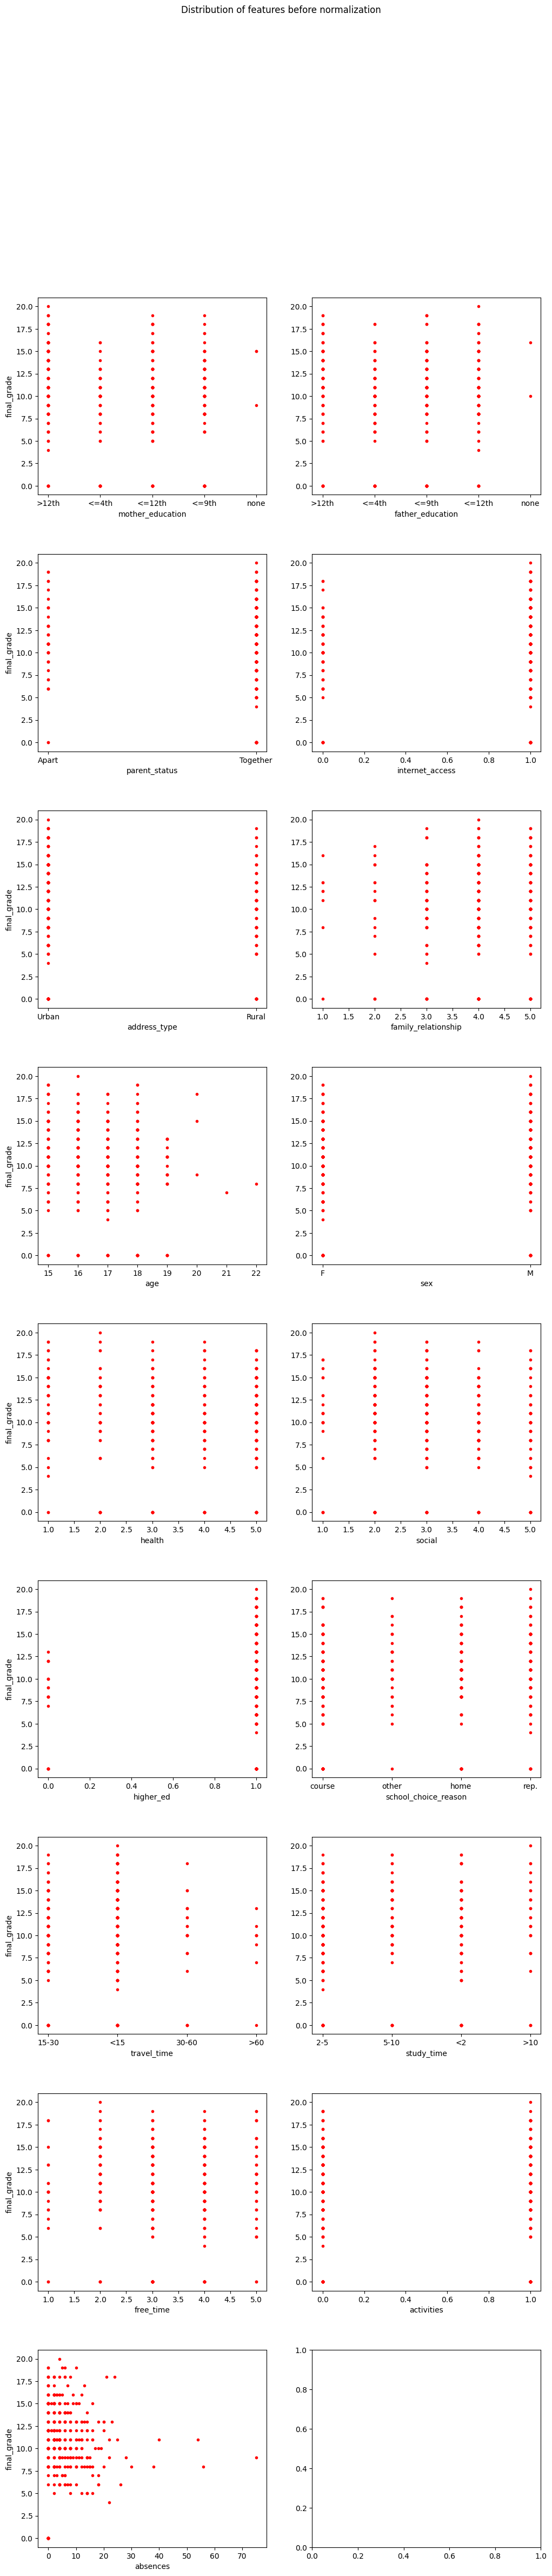

In [27]:
import matplotlib.pyplot as plt
import math
# Update the number of total features: fields - target
n = len(df_all.columns) - 1

# Subplot shape
n_cols = 2
n_rows = math.ceil(n/n_cols)

# Prepare labels to select x and y arrays for plotting
features = df_all.columns.drop('final_grade')
target = 'final_grade'
n_plotted = 0  # Number of graphs plotted when iteration starts; index for features list

# Create the subplots and assign to each axis a plot of feature_i vs final_grade
fig,ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*6), gridspec_kw={'hspace': 0.3})
for row in range(n_rows):
    for col in range(n_cols):
        if (n_plotted < n):
            i = n_cols*row + col
            ax[row, col].scatter(df[features[i]], df[target], marker='.', c='r')
            ax[row, col].set_xlabel(features[i])
            if col == 0:
                ax[row, col].set_ylabel(target)
            n_plotted += 1
fig.suptitle("Distribution of features before normalization")
plt.show()

## Modeling


## Results


## Conclusion


## References
